# Comparing ndmg branches

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Metadata

- This analysis uses the KKI2009 data <a href="http://mrneurodata.s3-website-us-east-1.amazonaws.com/KKI2009/" target="_blank">here</a>.
- Docker containers were used.
    - <a href="https://hub.docker.com/r/bids/ndmg/" target="_blank">master</a>
    - <a href="https://hub.docker.com/r/neurodata/m3r-release/" target="_blank">eric's branch</a>.
- I used the outputs in 
    - **master**: /graphs/ (.edgelist)
    - **eric**: /dwi/roi-connectomes (csv)

## Plan

1. Eric
    - Load data as np array
    - Convert to adjacency matrix
2. Master
    - Load data as np array
    - Convert to adjacency matrixc
3. Define a function that takes a file location as input and returns an adjacency matrix as output
    - Check whether file location is from master or eric
    - Possibly needs to do different things depending on which branch it's taking data from
4. For each pair of supposedly-equivalent graphs, take the difference
5. Take the norm of the above
6. Use seaborn to plot this for every parcellation
7. Equivalent analysis for group-level data

## Show where data is coming from

In [2]:
# Show the data I ran on in a tree structure. Ignore the \xa0\xa0's. Ran on 3 of the subjects from the KKI2009 dataset.
%system tree -d -L 3 /data/aloftus/KKI2009

['/data/aloftus/KKI2009',
 '├── sub-113',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '├── sub-127',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '└── sub-142',
 '    ├── ses-1',
 '    │\xa0\xa0 ├── anat',
 '    │\xa0\xa0 ├── dwi',
 '    │\xa0\xa0 └── func',
 '    └── ses-2',
 '        ├── anat',
 '        ├── dwi',
 '        └── func',
 '',
 '27 directories']

In [3]:
# Show eric's branch output dir
%system tree -d -L 2 /data/aloftus/KKI-output/eric-branch/participant/dwi

['/data/aloftus/KKI-output/eric-branch/participant/dwi',
 '├── fiber',
 '├── preproc',
 '├── registered',
 '├── roi-connectomes',
 '│\xa0\xa0 ├── aal_res-1x1x1',
 '│\xa0\xa0 ├── brodmann_res-1x1x1',
 '│\xa0\xa0 ├── CPAC200_res-1x1x1',
 '│\xa0\xa0 ├── desikan_res-1x1x1',
 '│\xa0\xa0 ├── DK_res-1x1x1',
 '│\xa0\xa0 ├── DS00071_res-1x1x1',
 '│\xa0\xa0 ├── DS00096_res-1x1x1',
 '│\xa0\xa0 ├── DS00108_res-1x1x1',
 '│\xa0\xa0 ├── DS00140_res-1x1x1',
 '│\xa0\xa0 ├── DS00195_res-1x1x1',
 '│\xa0\xa0 ├── DS00278_res-1x1x1',
 '│\xa0\xa0 ├── DS00350_res-1x1x1',
 '│\xa0\xa0 ├── DS00446_res-1x1x1',
 '│\xa0\xa0 ├── DS00583_res-1x1x1',
 '│\xa0\xa0 ├── DS00833_res-1x1x1',
 '│\xa0\xa0 ├── DS01216_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordcort-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordsub-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── hemispheric_res-1x1x1',
 '│\xa0\xa0 ├── JHU_res-1x1x1',
 '│\xa0\xa0 ├── slab1068_res-1x1x1',
 '│\xa0\xa0 ├── slab907_res-1x1x1',
 '│\xa0\xa0 └── tissue_res-1x1x1',
 '├

In [4]:
# Show master branch output dir
%system tree -d -L 2 /data/aloftus/KKI-output/master/graphs

['/data/aloftus/KKI-output/master/graphs',
 '├── AAL',
 '├── CPAC200',
 '├── desikan',
 '├── Desikan2012',
 '├── DS00071',
 '├── DS00096',
 '├── DS00108',
 '├── DS00140',
 '├── DS00195',
 '├── DS00278',
 '├── DS00350',
 '├── DS00446',
 '├── DS00583',
 '├── DS00833',
 '├── DS01216',
 '├── DS01876',
 '├── DS03231',
 '├── DS06481',
 '├── DS16784',
 '├── DS72784',
 '├── HarvardOxford',
 '├── JHU',
 '├── slab1068',
 '├── slab907',
 '└── Talairach',
 '',
 '25 directories']

## Load data

### Grab output for one subject, one session

- Using JHU, sub-113, ses-1 for testing purposes

In [5]:
# Save directory data
eric_graphs = r'/data/aloftus/KKI-output/eric-branch/participant/dwi/roi-connectomes/JHU_res-1x1x1/'
master_graphs = r'/data/aloftus/KKI-output/master/graphs/JHU/'

In [6]:
# Show output csv files. Arbitrarily using ses-1 of sub-113 as testing data.
print(os.listdir(eric_graphs), '\n')
print(os.listdir(master_graphs))

['sub-127_ses-2_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-127_ses-1_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-1_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-113_ses-2_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-2_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-113_ses-1_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv'] 

['sub-113_ses-2_dwi_JHU.edgelist', 'sub-142_ses-2_dwi_JHU.edgelist', 'sub-127_ses-2_dwi_JHU.edgelist', 'sub-127_ses-1_dwi_JHU.edgelist', 'sub-113_ses-1_dwi_JHU.edgelist', 'sub-142_ses-1_dwi_JHU.edgelist']


In [7]:
# Get networkX graph for eric's sub-113-ses-1-JHU
eric_edgelist_location = eric_graphs + 'sub-113_ses-1_dwi_JHU_res-1x1x1_measure-spatial-ds._elist.csv'
eric_nx = nx.read_weighted_edgelist(eric_edgelist_location, delimiter=',')

# Get networkX graph for masters's sub-113-ses-1-JHU
master_edgelist_location = master_graphs + 'sub-113_ses-1_dwi_JHU.edgelist'
master_nx = nx.read_weighted_edgelist(master_edgelist_location)

## quick info about these two graphs
---

In [8]:
eric_nx.nodes()

NodeView(('45', '48', '33', '40', '19', '35', '21', '13', '28', '11', '9', '14', '23', '7', '17', '6', '47', '25', '31', '12', '30', '3', '5', '10', '29', '44', '15', '20', '37', '42', '41', '46', '43', '27', '36', '39', '34', '8', '18', '24', '26', '1', '4', '22', '32', '16', '38', '2'))

In [9]:
master_nx.nodes()

NodeView(('45', '48', '33', '40', '19', '35', '21', '13', '28', '11', '9', '14', '23', '7', '17', '6', '47', '38', '25', '31', '12', '30', '3', '5', '10', '29', '44', '15', '20', '37', '42', '41', '46', '43', '27', '16', '39', '34', '8', '18', '26', '1', '4', '22', '32', '36', '24', '2'))

---

## Convert to more readable format

In [26]:
eric_mat = nx.to_numpy_matrix(eric_nx)
master_mat = nx.to_numpy_matrix(master_nx)

In [27]:
np.fill_diagonal(eric_mat, 0)

In [28]:
eric_mat.astype(int)

matrix([[  0,   0, 508, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [508,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0, 533],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 533,   0,   0]])

In [29]:
master_mat.astype(int)

matrix([[   0,    0,   77, ...,    0,    0,    0],
        [   0,    0,    0, ...,   11,    0,    0],
        [  77,    0,    0, ...,    0, 2676,    0],
        ...,
        [   0,   11,    0, ...,    0,  795,    0],
        [   0,    0, 2676, ...,  795,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]])

In [30]:
np.linalg.norm(eric_mat - master_mat, ord='fro')

81230.52427505316

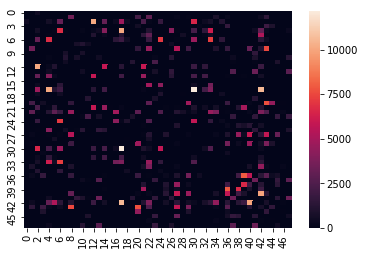

In [31]:
sns.heatmap(eric_mat.astype(int))

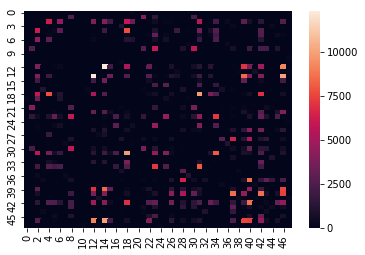

In [32]:
sns.heatmap(master_mat.astype(int))

## Function to load and compare graphs

Function should: 
1. Load a pair of graphs
2. Ensure they're in a consistent and sensible format (e.g., adjacency matrix)
3. Subtract one graph from the other
4. Take the norm of the result

In [14]:
def load_and_compare(master: 'path', eric: 'path'):
    
    # Load a pair of graphs
    graph_pair = [nx.read_weighted_edgelist(master), nx.read_weighted_edgelist(eric, delimiter=',')]
    
    # Move each graph to adjacency matrix
    graph_pair = [nx.adj_matrix(graph_pair[0]), nx.adj_matrix(graph_pair)]
    
    # Subtract one graph from the other
    diff_mat = graph_pair[0] - graph_pair[1]
    
    # Take norm of result
    pass

## nx playground, to be removed

In [15]:
G = nx.Graph()
G.add_edge(24, 24, weight=4150)
G.add_edge(25, 25, weight=2300)

nx.to_numpy_array(G)  # numpy array is not organized the same way as the edgelist file.
nx.to_edgelist(G)

EdgeDataView([(24, 24, {'weight': 4150}), (25, 25, {'weight': 2300})])

### Master output